In [1]:

## copying old work of mine https://github.com/btatkinson/NCAA-basketball-Capstone/blob/main/notebooks/blake_exploratory/team_network_demo_fake_data.ipynb
import torch
import random

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from copy import copy
from tqdm import tqdm
from faker import Faker
from itertools import combinations


## Team Network demo
The goal of this notebook is to show network concepts that can aid college basketball analysis

- I'll start in the abstract, with simulated scores.  
- Then I'll move to actual CBB data  

In [2]:

nodes = {}

G = nx.DiGraph()
G.add_nodes_from(['A','B','C','D'])
# Specify the edges you want here
red_edges = [('A','D')]
black_edges = [('A','B'),('C','D'),('B','C')]
black_edge_labels = {
    ('A','B'):'Beat',
    ('C','D'):'Beat',
    ('B','C'):'Beat'
}
red_edge_labels = {
    ('A','D'):'?'
}
G.add_edges_from(red_edges+black_edges)
edge_colors = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]


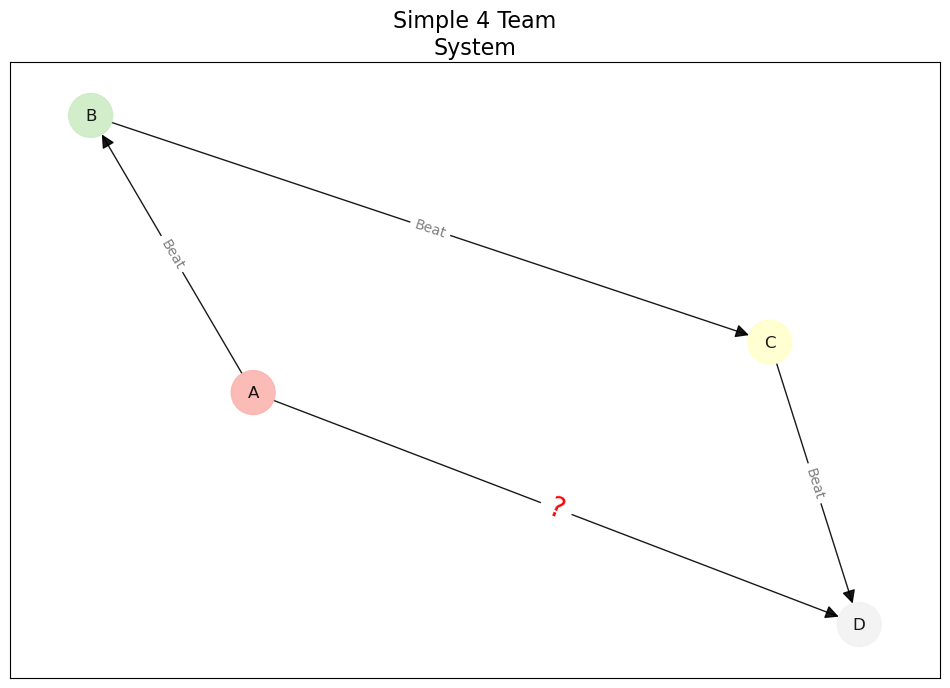

In [3]:


values = [0, 0.33, 0.66, 1]
fig, ax = plt.subplots(figsize=(12,8))
# Need to create a layout when doing
# separate calls to draw nodes and edges

pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('cool'), 
#                        node_color = values, node_size = 500)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='g', arrowsize=20, arrows=True)
nx.draw_networkx(G, pos, edge_color='black', width=1, linewidths=1, arrowsize=20, node_color=values, node_size=1000, cmap='Pastel1', alpha=0.9,labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=black_edge_labels,
    font_color='gray'
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=red_edge_labels,
    font_color='red',
    font_size=20
)
# nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrowsize=20, arrows=True)
plt.annotate("test",(0.5,0.5))
plt.title('Simple 4 Team\nSystem',fontsize=16)
plt.savefig('C://Users/Blake/Downloads/PageRank_simple.png')
plt.show()

In [4]:


# Randomly generate game results with noise centered around true skill

def play_game(skill_1, skill_2, vol=3):
    return np.random.normal(skill_1, vol) - np.random.normal(skill_2, vol)


def play_season(schedule, skill_dict_a, skill_dict_b):
    
    game_results = []
    
    for game in schedule:
        
        team_1_true_skill_a = skill_dict_a[game[0]]
        team_2_true_skill_a = skill_dict_a[game[1]]
        team_1_true_skill_b = skill_dict_b[game[0]]
        team_2_true_skill_b = skill_dict_b[game[1]]
        
        game_result_a = play_game(team_1_true_skill_a, team_2_true_skill_a)
        game_result_b = play_game(team_1_true_skill_b, team_2_true_skill_b)
        
        game_results.append([game[0], game[1], game_result_a, game_result_b])
        game_results.append([game[1], game[0], -1*game_result_a, -1*game_result_b])
    return pd.DataFrame(game_results, columns=['player_1','player_2','result_a','result_b'])




In [5]:


def calc_multiple_ratings(rtg_matrix, player_rtgs, num_players, num_iterations=100):

        dampen = 1/(num_players**2)
        A = (dampen * rtg_matrix + (1 - dampen) / num_players) 
        v = torch.clone(player_rtgs)

        for i in range(num_iterations):
            v = torch.einsum('ijk,jk->ik', A, v)
            norm = torch.linalg.norm(v, axis=0)
            v = v/norm
        return v*num_players

def run_prank_sim():
    ## need to normalize true rating since it is relative

    fake = Faker()

    # generate teams
    players = pd.DataFrame([(fake.name(), np.random.normal(0, 1)) for i in range(18)], columns=['name', 'true_rating_a'])
    players['true_rating_b'] = [np.random.normal(0, 1) for i in range(18)]

    # need to normalize
    players['normalized_rating_a']  = (players['true_rating_a'] - players['true_rating_a'].mean())/players['true_rating_a'].std()
    players['normalized_rating_b']  = (players['true_rating_b'] - players['true_rating_b'].mean())/players['true_rating_b'].std()

    
    skill_dict_a = players.copy().set_index('name').to_dict()['normalized_rating_a']
    skill_dict_b = players.copy().set_index('name').to_dict()['normalized_rating_b']
    
    num_players = len(skill_dict_a.keys()) 
    num_stats = 2
    result_matrix = torch.zeros((num_players, num_players, num_stats))
    
    name2id = {name:i for i,name in enumerate(skill_dict_a.keys())}
    id2name = {v:k for k,v in name2id.items()}

    schedule = list(combinations(list(players.name.values),2))

    game_results = play_season(schedule, skill_dict_a, skill_dict_b)
    update = game_results.copy()
    update['winner_index_a'] = np.where(update['result_a']>0, update['player_1'].map(name2id), update['player_2'].map(name2id))
    update['loser_index_a'] = np.where(update['result_a']>0, update['player_2'].map(name2id), update['player_1'].map(name2id))
    update['winner_index_b'] = np.where(update['result_b']>0, update['player_1'].map(name2id), update['player_2'].map(name2id))
    update['loser_index_b'] = np.where(update['result_b']>0, update['player_2'].map(name2id), update['player_1'].map(name2id))
    update = update.drop_duplicates(subset=['winner_index_a','loser_index_a','winner_index_b']).reset_index(drop=True)
    
    update_torch_indices = torch.from_numpy(update[['winner_index_a','loser_index_a']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_a'].abs().astype('float32').values)
    result_matrix[update_torch_indices[:, 0], update_torch_indices[:, 1], 0] = update_torch_values
    
    update_torch_indices = torch.from_numpy(update[['winner_index_b','loser_index_b']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_b'].abs().astype('float32').values)
    result_matrix[update_torch_indices[:, 0], update_torch_indices[:, 1], 1] = update_torch_values

    ## with dampening, not a symmetrical result
    ## have to do reverse and average the two
    rev_result_matrix = torch.zeros((num_players, num_players, num_stats))
    update_torch_indices = torch.from_numpy(update[['winner_index_a','loser_index_a']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_a'].abs().astype('float32').values)
    rev_result_matrix[update_torch_indices[:, 1], update_torch_indices[:, 0], 0] = update_torch_values

    update_torch_indices = torch.from_numpy(update[['winner_index_b','loser_index_b']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_b'].abs().astype('float32').values)
    rev_result_matrix[update_torch_indices[:, 1], update_torch_indices[:, 0], 1] = update_torch_values
    
    rec_ratings = calc_multiple_ratings(result_matrix, torch.rand((num_players, 2)), num_players)
    rev_rec_ratings = calc_multiple_ratings(rev_result_matrix, torch.rand((num_players, 2)), num_players)

    players = [id2name[i] for i in range(num_players)]
    df_eval = pd.DataFrame({
        'name':players,
        'true_a':[skill_dict_a[p] for p in players],
        'true_b':[skill_dict_b[p] for p in players],
        'recovered_a':[float(n) for n in list(rec_ratings[:,0])],
        'recovered_b':[float(n) for n in list(rec_ratings[:,1])],
        'rev_recovered_a':[float(n) for n in list(rev_rec_ratings[:,0])],
        'rev_recovered_b':[float(n) for n in list(rev_rec_ratings[:,1])]
    })

    df_eval['normalized_recovered_a']  = (df_eval['recovered_a'] - df_eval['recovered_a'].mean())/df_eval['recovered_a'].std()
    df_eval['normalized_recovered_b']  = (df_eval['recovered_b'] - df_eval['recovered_b'].mean())/df_eval['recovered_b'].std()
    df_eval['normalized_rev_recovered_a']  = (df_eval['rev_recovered_a'] - df_eval['rev_recovered_a'].mean())/df_eval['rev_recovered_a'].std()
    df_eval['normalized_rev_recovered_b']  = (df_eval['rev_recovered_b'] - df_eval['rev_recovered_b'].mean())/df_eval['rev_recovered_b'].std()

    df_eval['pagerank_norm_a'] = (df_eval['normalized_recovered_a'].copy()+-1*df_eval['normalized_rev_recovered_a'].copy())/2
    df_eval['pagerank_norm_b'] = (df_eval['normalized_recovered_b'].copy()+-1*df_eval['normalized_rev_recovered_b'].copy())/2

    df_eval = df_eval.drop(columns=['recovered_a','recovered_b','rev_recovered_a','rev_recovered_b','normalized_recovered_a',
                                   'normalized_rev_recovered_a','normalized_recovered_b','normalized_rev_recovered_b'])

    return update, df_eval


class EloRating():
    def __init__(self, mu=1500):
        self.mu = mu
        self.games_played = 0


        
def play_single_match(p1, p2, result, k=24):
    exp = 1/(1+10**((p2.mu-p1.mu)/400))
    mod = k*(result-exp)
    return mod


def add_elo_sim(res, eval_data):
    
    res['winner_a'] = np.where(res['result_a']>0, 1, 0)
    res['winner_b'] = np.where(res['result_b']>0, 1, 0)
    
    
    elo_rtgs_a = {}
    elo_rtgs_b = {}
    for name in set(res['player_1']).union(set(res['player_2'].unique())):
        elo_rtgs_a[name] = EloRating()
        elo_rtgs_b[name] = EloRating()
        
    res = res.sample(frac=1).reset_index(drop=True)
    
    for index, row in res.iterrows():
        p1 = row['player_1']
        p2 = row['player_2']

        p1_rtg_a = elo_rtgs_a[p1]
        p2_rtg_a = elo_rtgs_a[p2]
        mod_a = play_single_match(p1_rtg_a, p2_rtg_a, row['result_a'])
        p1_rtg_a.mu+=mod_a
        p2_rtg_a.mu-=mod_a
        elo_rtgs_a[p1] = copy(p1_rtg_a)
        elo_rtgs_a[p2] = copy(p2_rtg_a)

        p1_rtg_b = elo_rtgs_b[p1]
        p2_rtg_b = elo_rtgs_b[p2]
        mod_b = play_single_match(p1_rtg_b, p2_rtg_b, row['result_b'])
        p1_rtg_b.mu+=mod_b
        p2_rtg_b.mu-=mod_b

        elo_rtgs_b[p1] = copy(p1_rtg_b)
        elo_rtgs_b[p2] = copy(p2_rtg_b)


    eval_data['elo_mu_a'] = eval_data['name'].apply(lambda x: elo_rtgs_a[x].mu)
    eval_data['elo_mu_b'] = eval_data['name'].apply(lambda x: elo_rtgs_b[x].mu)
    
    eval_data['norm_elo_mu_a'] = (eval_data['elo_mu_a'] - eval_data['elo_mu_a'].mean())/eval_data['elo_mu_a'].std()
    eval_data['norm_elo_mu_b'] = (eval_data['elo_mu_b'] - eval_data['elo_mu_b'].mean())/eval_data['elo_mu_b'].std()
    
    eval_data = eval_data.drop(columns=['elo_mu_a','elo_mu_b'])

    return res, eval_data



game_results, df_eval = run_prank_sim()
game_results, df_eval = add_elo_sim(game_results.copy(), df_eval.copy())



In [6]:
import gc
### test a bunch of times
n = 500
elo_errors = []
pr_errors = []
for i in tqdm(range(n)):
    
    game_results, df_eval = run_prank_sim()
    game_results, df_eval = add_elo_sim(game_results.copy(), df_eval.copy())
    df_eval['elo_error_a'] = (df_eval['true_a']-df_eval['norm_elo_mu_a'])**2
    df_eval['elo_error_b'] = (df_eval['true_b']-df_eval['norm_elo_mu_b'])**2
    df_eval['pagerank_error_a'] = (df_eval['true_a']-df_eval['pagerank_norm_a'])**2
    df_eval['pagerank_error_b'] = (df_eval['true_b']-df_eval['pagerank_norm_b'])**2
    pr_errors.extend([df_eval['pagerank_error_a'].mean(), df_eval['pagerank_error_b'].mean()])
    elo_errors.extend([df_eval['elo_error_a'].mean(), df_eval['elo_error_b'].mean()])
    del df_eval
    del game_results
    gc.collect()

## one more time for plotting's sake
game_results, df_eval = run_prank_sim()
game_results, df_eval = add_elo_sim(game_results.copy(), df_eval.copy())


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.53it/s]


In [7]:
df_eval.corr(numeric_only=True)

,true_a,true_b,pagerank_norm_a,pagerank_norm_b,norm_elo_mu_a,norm_elo_mu_b
true_a,1.000000,0.020694,0.743944,0.134317,0.711648,0.054322
true_b,0.020694,1.000000,-0.049984,0.809086,-0.132062,0.747336
pagerank_norm_a,0.743944,-0.049984,1.000000,-0.087882,0.979864,-0.181677
pagerank_norm_b,0.134317,0.809086,-0.087882,1.000000,-0.148397,0.963601
norm_elo_mu_a,0.711648,-0.132062,0.979864,-0.148397,1.000000,-0.195415
norm_elo_mu_b,0.054322,0.747336,-0.181677,0.963601,-0.195415,1.000000


In [8]:

print(f"Elo avg error: {np.mean(elo_errors)}")
print(f"PageRank avg error: {np.mean(pr_errors)}")



Elo avg error: 0.5824308739876833
PageRank avg error: 0.512966050845869


In [19]:
(0.565-.501)/.501

0.1277445109780438

In [9]:

df_eval.corr(numeric_only=True)


,true_a,true_b,pagerank_norm_a,pagerank_norm_b,norm_elo_mu_a,norm_elo_mu_b
true_a,1.000000,0.020694,0.743944,0.134317,0.711648,0.054322
true_b,0.020694,1.000000,-0.049984,0.809086,-0.132062,0.747336
pagerank_norm_a,0.743944,-0.049984,1.000000,-0.087882,0.979864,-0.181677
pagerank_norm_b,0.134317,0.809086,-0.087882,1.000000,-0.148397,0.963601
norm_elo_mu_a,0.711648,-0.132062,0.979864,-0.148397,1.000000,-0.195415
norm_elo_mu_b,0.054322,0.747336,-0.181677,0.963601,-0.195415,1.000000


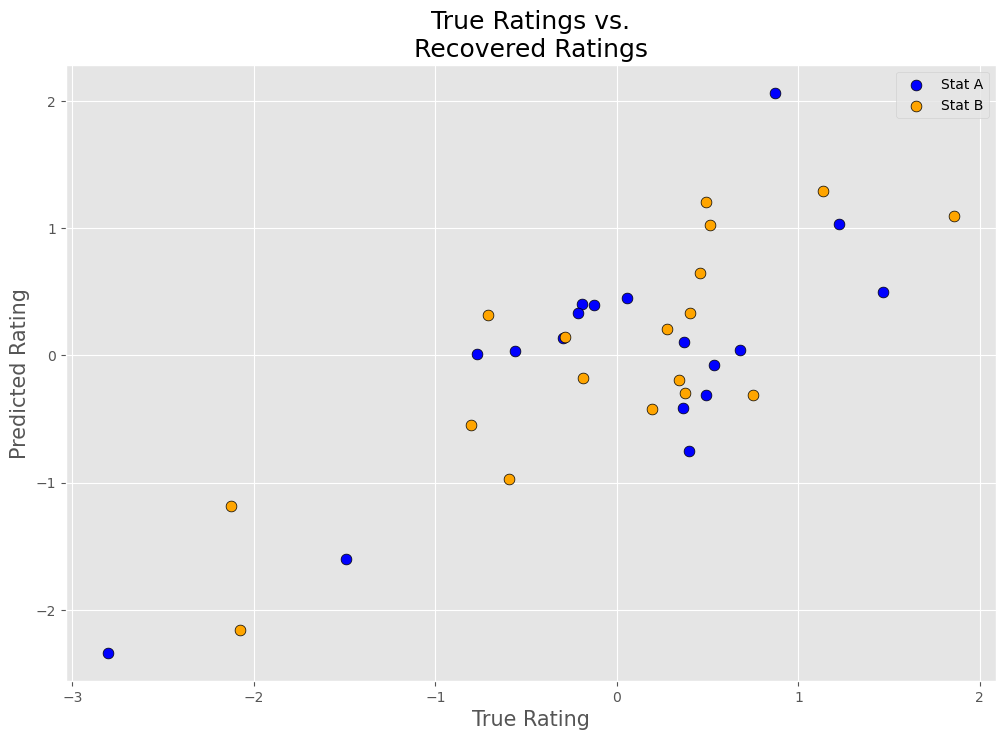

In [10]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(df_eval.true_a, df_eval.pagerank_norm_a, color='blue', label='Stat A', edgecolors='black', s=60)
ax.scatter(df_eval.true_b, df_eval.pagerank_norm_b, color='orange', label= 'Stat B', edgecolors='black', s=60)
ax.set_xlabel('True Rating',fontsize=15)
ax.set_ylabel('Predicted Rating',fontsize=15)

ax.set_title("True Ratings vs.\nRecovered Ratings",fontsize=18)
ax.legend()

plt.savefig('C://Users/Blake/Downloads/pagerank_simple.png')
plt.show()



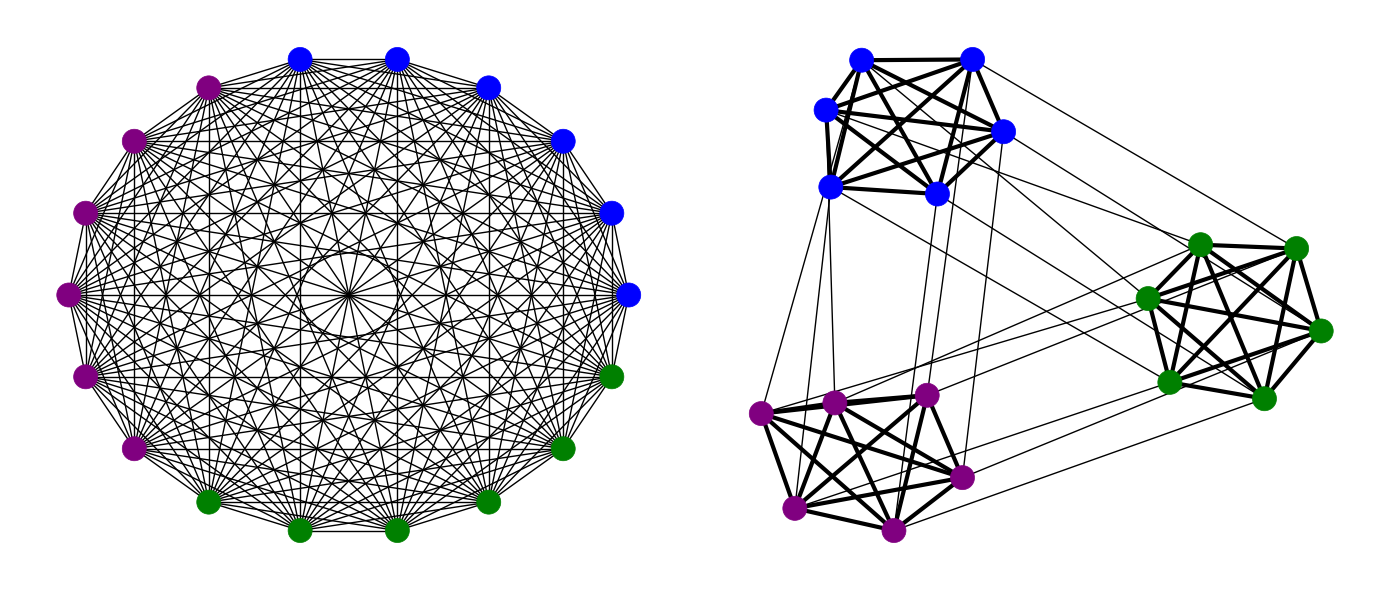

In [21]:



def get_conference_schedule(teams):
    
    """
    
    Generates conference and non-con schedule with each team playing each team in their conference 3 times
    2 non-con games, one from each other conference
    
    """
    
    team_names = list(teams.name)
    random.shuffle(team_names)
    conf_affiliation = {

    }
    conf_a_teams = []
    conf_b_teams = []
    conf_c_teams = []

    for conf_a_name in team_names[:6]:
        conf_affiliation[conf_a_name] = 'A'
        conf_a_teams.append(conf_a_name)
    for conf_b_name in team_names[6:12]:
        conf_affiliation[conf_b_name] = 'B'
        conf_b_teams.append(conf_b_name)
    for conf_c_name in team_names[12:]:
        conf_affiliation[conf_c_name] = 'C'
        conf_c_teams.append(conf_c_name)

    conf_a_schedule = list(combinations(conf_a_teams,2)) * 3
    conf_b_schedule = list(combinations(conf_b_teams,2)) * 3
    conf_c_schedule = list(combinations(conf_c_teams,2)) * 3

    full_schedule = conf_a_schedule + conf_b_schedule + conf_c_schedule

    for i in range(6):
        full_schedule.extend([(conf_a_teams[i], conf_b_teams[i]), (conf_a_teams[i], conf_c_teams[i]), (conf_c_teams[i], conf_b_teams[i])])

    assert(len(full_schedule)==153)
    teams['conf_name'] = teams['name'].map(conf_affiliation)
    
    return conf_affiliation, full_schedule

fake = Faker()

# generate teams
teams = pd.DataFrame([(fake.name(), np.random.normal(0, 1)) for i in range(18)], columns=['name', 'true_rating_a'])
conf_affiliation, conf_schedule = get_conference_schedule(teams)
# change conf_schedule to weighted graph
conf_schedule = pd.DataFrame(conf_schedule, columns=['team_1','team_2']).drop_duplicates().reset_index(drop=True)
conf_schedule['team_1_conf'] = conf_schedule['team_1'].map(conf_affiliation)
conf_schedule['team_2_conf'] = conf_schedule['team_2'].map(conf_affiliation)
conf_schedule['weight'] = np.where(conf_schedule['team_1_conf'].copy()==conf_schedule['team_2_conf'].copy(), 3, 1)

conf_schedule = list(conf_schedule[['team_1','team_2','weight']].values)
conf_schedule = [tuple(row) for row in conf_schedule]

### illustrating ###

g1 = nx.MultiGraph()
g2 = nx.Graph()

team_order = list(teams.name.values)
g1.add_nodes_from(list(team_order))
g2.add_nodes_from(list(team_order))
schedule = list(combinations(list(teams.name.values),2))
g1.add_edges_from(schedule)
g2.add_weighted_edges_from(conf_schedule)

conf_colormap = {
    'A':'blue',
    'B':'green',
    'C':'purple'
}
colormap = []
for node in g2:
    colormap.append(conf_colormap[conf_affiliation[node]])
fig, axes = plt.subplots(1, 2, figsize=(14,6))

ax1 = axes[0]
ax2 = axes[1]
# ax1.set_title('Fully Connected\nSchedule',fontsize=18)
# ax2.set_title('Conference\nSchedule',fontsize=18)
nx.draw_circular(g1, ax=ax1, node_color=['blue']*6+['purple']*6+['green']*6)
pos = nx.spring_layout(g2)
labels = nx.get_edge_attributes(g2,'weight')

weights = [g2[u][v]['weight'] for u,v in g2.edges()]
nx.draw_networkx(g2, pos, ax=ax2, node_color=colormap,width=weights,with_labels=False)
ax2.axis("off")
plt.tight_layout()
plt.savefig('C://Users/Blake/Downloads/pagerank_title.png')
# plt.savefig('C://Users/Blake/Downloads/pagerank_fully_conn.png')


In [24]:

def create_conf_schedule(conf_lists):
    con_or_non_con = ['con']*15+['non_con']*2
    random.shuffle(con_or_non_con)
    schedule = []
    a_players = conf_lists['A']
    b_players = conf_lists['B']
    c_players = conf_lists['C']
    for week,week_type in enumerate(con_or_non_con):
        random.shuffle(a_players)
        random.shuffle(b_players)
        random.shuffle(c_players)
        if week_type == 'con':
            for i in range(3):
                schedule.append([week, a_players[i*2], a_players[i*2+1]])
                schedule.append([week, b_players[i*2], b_players[i*2+1]])
                schedule.append([week, c_players[i*2], c_players[i*2+1]])
        if week_type == 'non_con':
            remaining = []
            for i in range(6):
                if i % 3 == 0:
                    schedule.append([week, a_players[i], b_players[i]])
                    remaining.append(c_players[i])
                elif i % 3 == 1:
                    schedule.append([week, b_players[i], c_players[i]])
                    remaining.append(a_players[i])
                elif i % 3 == 2:
                    schedule.append([week, a_players[i], c_players[i]])
                    remaining.append(b_players[i])
            for i in range(3):
                schedule.append([week, remaining[i*2], remaining[i*2+1]])
    return pd.DataFrame(schedule, columns=['week','player_1','player_2'])

def get_pagerank_ratings(conf_schedule, id2name, skill_dict_a, skill_dict_b):
    
    num_players = 18
    num_stats = 2
#     games_played_mat = torch.zeros((num_players, num_players, num_stats))
    rat_mat = torch.zeros((num_players, num_players, num_stats))
    rev_rat_mat = torch.zeros((num_players, num_players, num_stats))
    conf_schedule[['result_a','result_b']] = conf_schedule[['result_a','result_b']].astype('float32')
    quick_iterator = conf_schedule.groupby('week')
    for i, week_data in quick_iterator:

#         # add 1 to games played
#         games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 0] = games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 0] + 1
#         games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 0] = games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 0] + 1
#         games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 1] = games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 1] + 1
#         games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 1] = games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 1] + 1

        # update winner result and loser in rev result
        rat_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] = rat_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] + torch.from_numpy(np.abs(week_data.result_a.values))
        rat_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] = rat_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] + torch.from_numpy(np.abs(week_data.result_b.values))

        rev_rat_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] = rev_rat_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] + torch.from_numpy(np.abs(week_data.result_a.values))
        rev_rat_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] = rev_rat_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] + torch.from_numpy(np.abs(week_data.result_b.values))

    ## standardize by games played
#     rat_mat = rat_mat/(games_played_mat+1e-5)
#     rev_rat_mat = rev_rat_mat/(games_played_mat+1e-5)

    rec_ratings = calc_multiple_ratings(rat_mat, torch.rand((num_players, 2)), num_players)
    rev_rec_ratings = calc_multiple_ratings(rev_rat_mat, torch.rand((num_players, 2)), num_players)

    players = [id2name[i] for i in range(num_players)]
    df_eval = pd.DataFrame({
        'name':players,
        'true_a':[skill_dict_a[p] for p in players],
        'true_b':[skill_dict_b[p] for p in players],
        'recovered_a':[float(n) for n in list(rec_ratings[:,0])],
        'recovered_b':[float(n) for n in list(rec_ratings[:,1])],
        'rev_recovered_a':[float(n) for n in list(rev_rec_ratings[:,0])],
        'rev_recovered_b':[float(n) for n in list(rev_rec_ratings[:,1])]
    })

    df_eval['normalized_recovered_a']  = (df_eval['recovered_a'] - df_eval['recovered_a'].mean())/df_eval['recovered_a'].std()
    df_eval['normalized_recovered_b']  = (df_eval['recovered_b'] - df_eval['recovered_b'].mean())/df_eval['recovered_b'].std()
    df_eval['normalized_rev_recovered_a']  = (df_eval['rev_recovered_a'] - df_eval['rev_recovered_a'].mean())/df_eval['rev_recovered_a'].std()
    df_eval['normalized_rev_recovered_b']  = (df_eval['rev_recovered_b'] - df_eval['rev_recovered_b'].mean())/df_eval['rev_recovered_b'].std()

    df_eval['pagerank_norm_a'] = (df_eval['normalized_recovered_a'].copy()+-1*df_eval['normalized_rev_recovered_a'].copy())/2
    df_eval['pagerank_norm_b'] = (df_eval['normalized_recovered_b'].copy()+-1*df_eval['normalized_rev_recovered_b'].copy())/2

    df_eval = df_eval.drop(columns=['recovered_a','recovered_b','rev_recovered_a','rev_recovered_b','normalized_recovered_a',
                                   'normalized_rev_recovered_a','normalized_recovered_b','normalized_rev_recovered_b'])

    return df_eval

def add_elo_sim(res, eval_data):
    
    res['winner_a'] = np.where(res['result_a']>0, 1, 0)
    res['winner_b'] = np.where(res['result_b']>0, 1, 0)
    
    elo_rtgs_a = {}
    elo_rtgs_b = {}
    for name in set(res['player_1']).union(set(res['player_2'].unique())):
        elo_rtgs_a[name] = EloRating()
        elo_rtgs_b[name] = EloRating()
        
    res = res.sample(frac=1).reset_index(drop=True)
    
    for index, row in res.iterrows():
        p1 = row['player_1']
        p2 = row['player_2']

        p1_rtg_a = elo_rtgs_a[p1]
        p2_rtg_a = elo_rtgs_a[p2]
        mod_a = play_single_match(p1_rtg_a, p2_rtg_a, row['result_a'])
        p1_rtg_a.mu+=mod_a
        p2_rtg_a.mu-=mod_a
        elo_rtgs_a[p1] = copy(p1_rtg_a)
        elo_rtgs_a[p2] = copy(p2_rtg_a)

        p1_rtg_b = elo_rtgs_b[p1]
        p2_rtg_b = elo_rtgs_b[p2]
        mod_b = play_single_match(p1_rtg_b, p2_rtg_b, row['result_b'])
        p1_rtg_b.mu+=mod_b
        p2_rtg_b.mu-=mod_b

        elo_rtgs_b[p1] = copy(p1_rtg_b)
        elo_rtgs_b[p2] = copy(p2_rtg_b)


    eval_data['elo_mu_a'] = eval_data['name'].apply(lambda x: elo_rtgs_a[x].mu)
    eval_data['elo_mu_b'] = eval_data['name'].apply(lambda x: elo_rtgs_b[x].mu)
    
    eval_data['norm_elo_mu_a'] = (eval_data['elo_mu_a'] - eval_data['elo_mu_a'].mean())/eval_data['elo_mu_a'].std()
    eval_data['norm_elo_mu_b'] = (eval_data['elo_mu_b'] - eval_data['elo_mu_b'].mean())/eval_data['elo_mu_b'].std()
    
    eval_data = eval_data.drop(columns=['elo_mu_a','elo_mu_b'])

    return res, eval_data


def run_conference_sim():
    fake = Faker()

    # generate teams
    players = pd.DataFrame([(fake.name()) for i in range(18)], columns=['name'])
    players['conference']  = ['A']*6+['B']*6+['C']*6
    conf_skills = {
        'A':0.3,
        'B':0,
        'C':-0.3
    }
    players['true_rating_a'] = players['conference'].copy().apply(lambda x: np.random.normal(conf_skills[x], 1))
    players['true_rating_b'] = players['conference'].copy().apply(lambda x: np.random.normal(conf_skills[x], 1))


    # # need to normalize
    players['normalized_rating_a']  = (players['true_rating_a'] - players['true_rating_a'].mean())/players['true_rating_a'].std()
    players['normalized_rating_b']  = (players['true_rating_b'] - players['true_rating_b'].mean())/players['true_rating_b'].std()

    skill_dict_a = players.copy().set_index('name').to_dict()['normalized_rating_a']
    skill_dict_b = players.copy().set_index('name').to_dict()['normalized_rating_b']

    num_players = len(skill_dict_a.keys()) 
    num_stats = 2
    result_matrix = torch.zeros((num_players, num_players, num_stats))

    name2id = {name:i for i,name in enumerate(skill_dict_a.keys())}
    name2conf = players[['name','conference']].copy().set_index('name').to_dict()['conference']
    id2name = {v:k for k,v in name2id.items()}
    conf_lists = {
        'A':[],
        'B':[],
        'C':[]
    }
    for player in skill_dict_a.keys():
        conf_lists[name2conf[player]].append(player)
        
    try:
        assert(len(conf_lists['A'])==6), print(conf_lists) ## some weird bugs here, randomly won't populate about 0.005% of the time
        assert(len(conf_lists['B'])==6), print(conf_lists)
        assert(len(conf_lists['C'])==6), print(conf_lists) 

    except:
        ## skip iteration
        return None, None, False

    conf_schedule = create_conf_schedule(conf_lists.copy())

    conf_schedule['p1_index'] = conf_schedule['player_1'].map(name2id)
    conf_schedule['p2_index'] = conf_schedule['player_2'].map(name2id)
    conf_schedule['p1_skill_a'] = conf_schedule['player_1'].map(skill_dict_a)
    conf_schedule['p1_skill_b'] = conf_schedule['player_1'].map(skill_dict_b)
    conf_schedule['p2_skill_a'] = conf_schedule['player_2'].map(skill_dict_a)
    conf_schedule['p2_skill_b'] = conf_schedule['player_2'].map(skill_dict_b)
    conf_schedule['result_a'] = conf_schedule[['p1_skill_a','p2_skill_a']].copy().apply(lambda x: play_game(x.p1_skill_a, x.p2_skill_a), axis=1)
    conf_schedule['result_b'] = conf_schedule[['p1_skill_b','p2_skill_b']].copy().apply(lambda x: play_game(x.p1_skill_b, x.p2_skill_b), axis=1)
    conf_schedule['win_a'] = np.where(conf_schedule['result_a']>0, 1, 0)
    conf_schedule['win_b'] = np.where(conf_schedule['result_b']>0, 1, 0)

    conf_schedule['winner_index_a'] = np.where(conf_schedule['result_a']>0, conf_schedule['player_1'].map(name2id), conf_schedule['player_2'].map(name2id))
    conf_schedule['loser_index_a'] = np.where(conf_schedule['result_a']>0, conf_schedule['player_2'].map(name2id), conf_schedule['player_1'].map(name2id))
    conf_schedule['winner_index_b'] = np.where(conf_schedule['result_b']>0, conf_schedule['player_1'].map(name2id), conf_schedule['player_2'].map(name2id))
    conf_schedule['loser_index_b'] = np.where(conf_schedule['result_b']>0, conf_schedule['player_2'].map(name2id), conf_schedule['player_1'].map(name2id))

    pr_ranks = get_pagerank_ratings(conf_schedule, id2name, skill_dict_a, skill_dict_b)
    conf_schedule, df_eval = add_elo_sim(conf_schedule.copy(), pr_ranks.copy())
    
    
    return conf_schedule, df_eval, True

import time
### test a bunch of times
n = 500
elo_errors = []
pr_errors = []
for i in tqdm(range(n)):
    
    game_results, df_eval, worked = run_conference_sim()
    if not worked:
        print("weird bug, skipping iteration")
        time.sleep(0.25)
        continue
    df_eval['elo_error_a'] = (df_eval['true_a']-df_eval['norm_elo_mu_a'])**2
    df_eval['elo_error_b'] = (df_eval['true_b']-df_eval['norm_elo_mu_b'])**2
    df_eval['pagerank_error_a'] = (df_eval['true_a']-df_eval['pagerank_norm_a'])**2
    df_eval['pagerank_error_b'] = (df_eval['true_b']-df_eval['pagerank_norm_b'])**2
    pr_errors.extend([df_eval['pagerank_error_a'].mean(), df_eval['pagerank_error_b'].mean()])
    elo_errors.extend([df_eval['elo_error_a'].mean(), df_eval['elo_error_b'].mean()])

    del df_eval
    del game_results
    gc.collect()

## fully connected
## Elo avg error: .565
## PageRank avg error: .501


## conf schedule 
## should be higher for both
## should be more drastic discrepancy
## Elo avg error: 0.6543053040190041
## PageRank avg error: 0.5929823534669142

print(f"Elo avg error: {np.mean(elo_errors)}")
print(f"PageRank avg error: {np.mean(pr_errors)}")




100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:11<00:00,  7.00it/s]

Elo avg error: 0.6543053040190041
PageRank avg error: 0.5929823534669142


In [26]:
(0.6543-0.593)/0.593

0.10337268128161893

In [27]:

def create_6_game_conf_schedule(conf_lists):
    con_or_non_con = ['con']*5+['non_con']*1
#     random.shuffle(con_or_non_con)
    schedule = []
    a_players = conf_lists['A']
    b_players = conf_lists['B']
    c_players = conf_lists['C']
    for week,week_type in enumerate(con_or_non_con):
        random.shuffle(a_players)
        random.shuffle(b_players)
        random.shuffle(c_players)
        if week_type == 'con':
            for i in range(3):
                schedule.append([week, a_players[i*2], a_players[i*2+1]])
                schedule.append([week, b_players[i*2], b_players[i*2+1]])
                schedule.append([week, c_players[i*2], c_players[i*2+1]])
        if week_type == 'non_con':
            remaining = []
            for i in range(6):
                if i % 3 == 0:
                    schedule.append([week, a_players[i], b_players[i]])
                    remaining.append(c_players[i])
                elif i % 3 == 1:
                    schedule.append([week, b_players[i], c_players[i]])
                    remaining.append(a_players[i])
                elif i % 3 == 2:
                    schedule.append([week, a_players[i], c_players[i]])
                    remaining.append(b_players[i])
            for i in range(3):
                schedule.append([week, remaining[i*2], remaining[i*2+1]])
    return pd.DataFrame(schedule, columns=['week','player_1','player_2'])

def get_pagerank_ratings(conf_schedule, id2name, skill_dict_a, skill_dict_b):
    
    num_players = 18
    num_stats = 2
#     games_played_mat = torch.zeros((num_players, num_players, num_stats))
    rat_mat = torch.zeros((num_players, num_players, num_stats))
    rev_rat_mat = torch.zeros((num_players, num_players, num_stats))
    conf_schedule[['result_a','result_b']] = conf_schedule[['result_a','result_b']].astype('float32')
    quick_iterator = conf_schedule.groupby('week')
    for i, week_data in quick_iterator:

#         # add 1 to games played
#         games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 0] = games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 0] + 1
#         games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 0] = games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 0] + 1
#         games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 1] = games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 1] + 1
#         games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 1] = games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 1] + 1

        # update winner result and loser in rev result
        rat_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] = rat_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] + torch.from_numpy(np.abs(week_data.result_a.values))
        rat_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] = rat_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] + torch.from_numpy(np.abs(week_data.result_b.values))

        rev_rat_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] = rev_rat_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] + torch.from_numpy(np.abs(week_data.result_a.values))
        rev_rat_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] = rev_rat_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] + torch.from_numpy(np.abs(week_data.result_b.values))

    ## standardize by games played
#     rat_mat = rat_mat/(games_played_mat+1e-5)
#     rev_rat_mat = rev_rat_mat/(games_played_mat+1e-5)

    rec_ratings = calc_multiple_ratings(rat_mat, torch.rand((num_players, 2)), num_players)
    rev_rec_ratings = calc_multiple_ratings(rev_rat_mat, torch.rand((num_players, 2)), num_players)

    players = [id2name[i] for i in range(num_players)]
    df_eval = pd.DataFrame({
        'name':players,
        'true_a':[skill_dict_a[p] for p in players],
        'true_b':[skill_dict_b[p] for p in players],
        'recovered_a':[float(n) for n in list(rec_ratings[:,0])],
        'recovered_b':[float(n) for n in list(rec_ratings[:,1])],
        'rev_recovered_a':[float(n) for n in list(rev_rec_ratings[:,0])],
        'rev_recovered_b':[float(n) for n in list(rev_rec_ratings[:,1])]
    })

    df_eval['normalized_recovered_a']  = (df_eval['recovered_a'] - df_eval['recovered_a'].mean())/df_eval['recovered_a'].std()
    df_eval['normalized_recovered_b']  = (df_eval['recovered_b'] - df_eval['recovered_b'].mean())/df_eval['recovered_b'].std()
    df_eval['normalized_rev_recovered_a']  = (df_eval['rev_recovered_a'] - df_eval['rev_recovered_a'].mean())/df_eval['rev_recovered_a'].std()
    df_eval['normalized_rev_recovered_b']  = (df_eval['rev_recovered_b'] - df_eval['rev_recovered_b'].mean())/df_eval['rev_recovered_b'].std()

    df_eval['pagerank_norm_a'] = (df_eval['normalized_recovered_a'].copy()+-1*df_eval['normalized_rev_recovered_a'].copy())/2
    df_eval['pagerank_norm_b'] = (df_eval['normalized_recovered_b'].copy()+-1*df_eval['normalized_rev_recovered_b'].copy())/2

    df_eval = df_eval.drop(columns=['recovered_a','recovered_b','rev_recovered_a','rev_recovered_b','normalized_recovered_a',
                                   'normalized_rev_recovered_a','normalized_recovered_b','normalized_rev_recovered_b'])

    return df_eval

def add_elo_sim(res, eval_data):
    
    res['winner_a'] = np.where(res['result_a']>0, 1, 0)
    res['winner_b'] = np.where(res['result_b']>0, 1, 0)
    
    elo_rtgs_a = {}
    elo_rtgs_b = {}
    for name in set(res['player_1']).union(set(res['player_2'].unique())):
        elo_rtgs_a[name] = EloRating()
        elo_rtgs_b[name] = EloRating()
        
    res = res.sample(frac=1).reset_index(drop=True)
    
    for index, row in res.iterrows():
        p1 = row['player_1']
        p2 = row['player_2']

        p1_rtg_a = elo_rtgs_a[p1]
        p2_rtg_a = elo_rtgs_a[p2]
        mod_a = play_single_match(p1_rtg_a, p2_rtg_a, row['result_a'])
        p1_rtg_a.mu+=mod_a
        p2_rtg_a.mu-=mod_a
        elo_rtgs_a[p1] = copy(p1_rtg_a)
        elo_rtgs_a[p2] = copy(p2_rtg_a)

        p1_rtg_b = elo_rtgs_b[p1]
        p2_rtg_b = elo_rtgs_b[p2]
        mod_b = play_single_match(p1_rtg_b, p2_rtg_b, row['result_b'])
        p1_rtg_b.mu+=mod_b
        p2_rtg_b.mu-=mod_b

        elo_rtgs_b[p1] = copy(p1_rtg_b)
        elo_rtgs_b[p2] = copy(p2_rtg_b)


    eval_data['elo_mu_a'] = eval_data['name'].apply(lambda x: elo_rtgs_a[x].mu)
    eval_data['elo_mu_b'] = eval_data['name'].apply(lambda x: elo_rtgs_b[x].mu)
    
    eval_data['norm_elo_mu_a'] = (eval_data['elo_mu_a'] - eval_data['elo_mu_a'].mean())/eval_data['elo_mu_a'].std()
    eval_data['norm_elo_mu_b'] = (eval_data['elo_mu_b'] - eval_data['elo_mu_b'].mean())/eval_data['elo_mu_b'].std()
    
    eval_data = eval_data.drop(columns=['elo_mu_a','elo_mu_b'])

    return res, eval_data


def run_6_game_conference_sim():
    fake = Faker()

    # generate teams
    players = pd.DataFrame([(fake.name()) for i in range(18)], columns=['name'])
    players['conference']  = ['A']*6+['B']*6+['C']*6
    conf_skills = {
        'A':0.3,
        'B':0,
        'C':-0.3
    }
    players['true_rating_a'] = players['conference'].copy().apply(lambda x: np.random.normal(conf_skills[x], 1))
    players['true_rating_b'] = players['conference'].copy().apply(lambda x: np.random.normal(conf_skills[x], 1))


    # # need to normalize
    players['normalized_rating_a']  = (players['true_rating_a'] - players['true_rating_a'].mean())/players['true_rating_a'].std()
    players['normalized_rating_b']  = (players['true_rating_b'] - players['true_rating_b'].mean())/players['true_rating_b'].std()

    skill_dict_a = players.copy().set_index('name').to_dict()['normalized_rating_a']
    skill_dict_b = players.copy().set_index('name').to_dict()['normalized_rating_b']

    num_players = len(skill_dict_a.keys()) 
    num_stats = 2
    result_matrix = torch.zeros((num_players, num_players, num_stats))

    name2id = {name:i for i,name in enumerate(skill_dict_a.keys())}
    name2conf = players[['name','conference']].copy().set_index('name').to_dict()['conference']
    id2name = {v:k for k,v in name2id.items()}
    conf_lists = {
        'A':[],
        'B':[],
        'C':[]
    }
    for player in skill_dict_a.keys():
        conf_lists[name2conf[player]].append(player)
        
    try:
        assert(len(conf_lists['A'])==6), print(conf_lists) ## some weird bugs here, randomly won't populate about 0.005% of the time
        assert(len(conf_lists['B'])==6), print(conf_lists)
        assert(len(conf_lists['C'])==6), print(conf_lists) 

    except:
        ## skip iteration
        return None, None, False

    conf_schedule = create_6_game_conf_schedule(conf_lists.copy())

    conf_schedule['p1_index'] = conf_schedule['player_1'].map(name2id)
    conf_schedule['p2_index'] = conf_schedule['player_2'].map(name2id)
    conf_schedule['p1_skill_a'] = conf_schedule['player_1'].map(skill_dict_a)
    conf_schedule['p1_skill_b'] = conf_schedule['player_1'].map(skill_dict_b)
    conf_schedule['p2_skill_a'] = conf_schedule['player_2'].map(skill_dict_a)
    conf_schedule['p2_skill_b'] = conf_schedule['player_2'].map(skill_dict_b)
    conf_schedule['result_a'] = conf_schedule[['p1_skill_a','p2_skill_a']].copy().apply(lambda x: play_game(x.p1_skill_a, x.p2_skill_a), axis=1)
    conf_schedule['result_b'] = conf_schedule[['p1_skill_b','p2_skill_b']].copy().apply(lambda x: play_game(x.p1_skill_b, x.p2_skill_b), axis=1)
    conf_schedule['win_a'] = np.where(conf_schedule['result_a']>0, 1, 0)
    conf_schedule['win_b'] = np.where(conf_schedule['result_b']>0, 1, 0)

    conf_schedule['winner_index_a'] = np.where(conf_schedule['result_a']>0, conf_schedule['player_1'].map(name2id), conf_schedule['player_2'].map(name2id))
    conf_schedule['loser_index_a'] = np.where(conf_schedule['result_a']>0, conf_schedule['player_2'].map(name2id), conf_schedule['player_1'].map(name2id))
    conf_schedule['winner_index_b'] = np.where(conf_schedule['result_b']>0, conf_schedule['player_1'].map(name2id), conf_schedule['player_2'].map(name2id))
    conf_schedule['loser_index_b'] = np.where(conf_schedule['result_b']>0, conf_schedule['player_2'].map(name2id), conf_schedule['player_1'].map(name2id))

    pr_ranks = get_pagerank_ratings(conf_schedule, id2name, skill_dict_a, skill_dict_b)
    conf_schedule, df_eval = add_elo_sim(conf_schedule.copy(), pr_ranks.copy())
    
    
    return conf_schedule, df_eval, True

import time
### test a bunch of times
n = 500
elo_errors = []
pr_errors = []
for i in tqdm(range(n)):
    
    game_results, df_eval, worked = run_6_game_conference_sim()
    if not worked:
        print("weird bug, skipping iteration")
        time.sleep(0.25)
        continue
    df_eval['elo_error_a'] = (df_eval['true_a']-df_eval['norm_elo_mu_a'])**2
    df_eval['elo_error_b'] = (df_eval['true_b']-df_eval['norm_elo_mu_b'])**2
    df_eval['pagerank_error_a'] = (df_eval['true_a']-df_eval['pagerank_norm_a'])**2
    df_eval['pagerank_error_b'] = (df_eval['true_b']-df_eval['pagerank_norm_b'])**2
    pr_errors.extend([df_eval['pagerank_error_a'].mean(), df_eval['pagerank_error_b'].mean()])
    elo_errors.extend([df_eval['elo_error_a'].mean(), df_eval['elo_error_b'].mean()])

    del df_eval
    del game_results
    gc.collect()


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.49it/s]


In [28]:

print(f"Elo avg error: {np.mean(elo_errors)}")
print(f"PageRank avg error: {np.mean(pr_errors)}")


Elo avg error: 0.9815989829312526
PageRank avg error: 0.8721550836394821


0.11967213114754087

In [16]:
## one more time for plotting's sake
conf_schedule, df_eval = run_conference_sim()
df_eval['elo_error_a'] = (df_eval['true_a']-df_eval['norm_elo_mu_a'])**2
df_eval['elo_error_b'] = (df_eval['true_b']-df_eval['norm_elo_mu_b'])**2
df_eval['pagerank_error_a'] = (df_eval['true_a']-df_eval['pagerank_norm_a'])**2
df_eval['pagerank_error_b'] = (df_eval['true_b']-df_eval['pagerank_norm_b'])**2
df_eval.mean()

C:\Users\Blake\AppData\Local\Temp\ipykernel_1584\2780920963.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_eval.mean()


true_a              7.131641e-18
true_b              1.850372e-17
pagerank_norm_a    -2.183439e-15
pagerank_norm_b     0.000000e+00
norm_elo_mu_a      -3.654484e-16
norm_elo_mu_b       8.635068e-17
elo_error_a         5.447574e-01
elo_error_b         7.039316e-01
pagerank_error_a    5.137243e-01
pagerank_error_b    6.136493e-01
dtype: float64